# Mengimport Library yang akan digunakan

Pemanggilan library dan package ini dilakukan agar Python selaku bahasa pemrograman dapat memproses perintah – perintah pemroses data. Library yang dipanggil diantaranya 
1. os untuk berinteraksi langsung dengan sistem operasi
2. re untuk melakukan hal – hal yang berhubungan dengan regular expression (REGEX)
3. numpy untuk pemrosesan matriks dan vektor 
4. pandas untuk manipulasi data
5. xarray untuk pemrosean array multidimensi dan koordinat
6. earthpy untuk pemrosesan data vektor dan data raster
7. rasterio untuk menulis dan membaca format data geospasial 
8. geopandas untuk pemodelan titik, garis dan polygon, 
9. rioxarray, untuk memanipulasi data spasial

In [7]:
import os
import re
import numpy as np
import pandas as pd
import xarray as xr
import earthpy as et
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr

from numpy import ma
from glob import glob
from shapely import speedups
from earthpy import mask as em
from earthpy import plot as ep
from rasterio import plot, mask
from earthpy import spatial as es
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches, colors

from rasterio.crs import CRS
from shapely.geometry import mapping
from earthpy.spatial import bytescale
from matplotlib.colors import ListedColormap, BoundaryNorm

speedups.disable()

# Membaca atau load Citra Landsat 8
**1. Membaca atau Load Citra Landsat 8**

Langkah yang pertama yang dilakukan yaitu membaca atau load citra landsat 8. <br>
Disini saya membaca atau meload citra landsat melalui folder yang tersimpan di laptop. Proses membaca atau meload citra landsat dapat dilakukan dengan script sebagai berikut :
> nama_variabel = "lokasi citra landsat 8"

Contoh 

> landsat_dir = "landsat_dir ="Citra/LC08_L2SP_122065_20150103_20200910_02_T1/"

**2. Menentukan Band Citra Landsat 8 yang akan digunakan**

Setelah citra landsat 8 dibaca selanjutnya dilakukan proses pemilihan band yang akan digunakan. Pada proses ini saya memilih beberapa band yaitu band 4, band 5, band 6, dan band QA pixel yang nantinya akan ditampung dalam sebuah variabel. Pemilihan band 4, band 5, band 6 bertujuan untuk menganalysis vegetation pada citra landsat 8, dan band QA pixel digunakan untuk melakukan proses penghapusan awan dan bayangan pada citra. Proses pemilihan band dapat dilakukan menggunakan script sebagai berikut :

> band_names = (4, 5, 6, "QA_PIXEL")

**3. Menentukan CRS (Coordinate Reference System)**

Selanjutnya menentukan crs (coordinate reference system) sesuai dengan daerah penelitian. Coordinate reference system (CRS) adalah sistem yang digunakan dalam pendefinisian kordinat dari suatu atau beberapa titik dalam ruang. <br>
EPSG (European Petroleum Survey Group) adalah registri publik datum geodetik , sistem referensi spasial , ellipsoid bumi , transformasi koordinat dan unit pengukuran terkait . Setiap entitas diberi kode EPSG antara 1024-32767, bersama dengan representasi teks terkenal (WKT) yang dapat dibaca mesin standar . Dataset secara aktif dikelola oleh IOGP Geomatics Committee. <br>
CRS yang digunakan adalah EPSG : 4326. EPSG:4326 adalah sistem kordinat yang memiliki proyeksi UTM 48 South dan datum WGS 84. Dimana UTM 48S merupakan Zona UTM untuk **Kota Bogor**. <br>
CRS ditampung dalam sebuah variabel. Untuk menentukan CRS dapat dilakukan menggunakan script berikut :

> coor_ref = "EPSG:4326"

**4. Membaca Citra Landsat 8 sesuai dengan Band yang ditentukan dan melakukan Georeferencing**

Setelah crs dan memilih band yang akan digunakan selanjutnya melakukan proses membaca citra landsat 8 dengan memilih beberapa band yang akan digunakan lalu dilakukan georeferencing pada masing band yang dipilih sesuai dengan CRS yang sudah ditentukan. Prosesnya dapat menggunakan script berikut : 
 
> raw_band = dict(zip(band_names, [rxr.open_rasterio(glob(f"{landsat_dir}*{i}.TIF*".format(i))[0], masked=True).squeeze().rio.reproject(CRS.from_string(coor_ref)) for i in band_names]))

In [8]:

landsat_dir ="Citra/LC08_L2SP_122065_20190911_20200826_02_T1/"
band_names = (4,5,6, "QA_PIXEL")
coor_ref = "EPSG:4326"
raw_band = dict(zip(band_names, [rxr.open_rasterio(glob(f"{landsat_dir}*{i}.TIF*".format(i))[0], 
                                                   masked=True).squeeze().rio.reproject(CRS.from_string(coor_ref)) 
                                 for i in band_names]))

````````
#landsat 8 L1C1
landsat_dir ="Citra/Mei 2020/"
band_names = (4,5,6, "QA")
coor_ref = "EPSG:4326"
raw_band = dict(zip(band_names, [rxr.open_rasterio(glob(f"{landsat_dir}*{i}.TIF*".format(i))[0], masked=True).squeeze().rio.reproject(CRS.from_string(coor_ref)) for i in band_names]))

````````

# Menampilkan Band yang akan digunakan
Untuk menampilkan band dapat menggunakan script berikut :

``````
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

i = 0
for j in range(2):
    for k in range(2):
        raw_band[[*raw_band.keys()][i]].plot.imshow(ax=axs[j, k], cmap="Greys_r", add_colorbar = False)
        axs[j, k].set_title(f"Band {[*raw_band.keys()][i]}")
        axs[j, k].set_xlabel("longitude")
        axs[j, k].set_ylabel("latitude")
        i += 1
        
plt.show()

``````

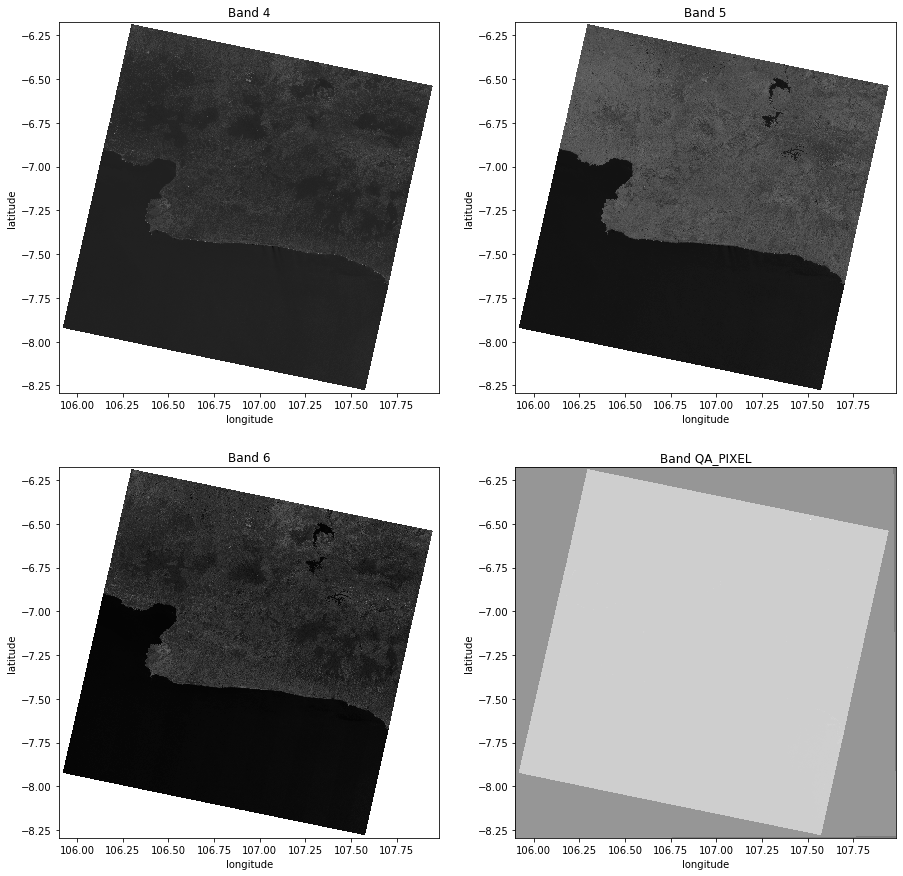

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

i = 0
for j in range(2):
    for k in range(2):
        raw_band[[*raw_band.keys()][i]].plot.imshow(ax=axs[j, k], cmap="Greys_r", add_colorbar = False)
        axs[j, k].set_title(f"Band {[*raw_band.keys()][i]}")
        axs[j, k].set_xlabel("longitude")
        axs[j, k].set_ylabel("latitude")
        i += 1
        
plt.show()

# Melakukan Kombinasi Kanal (BAND)

Tahap selanjutnya melakukan proses kombinasi kanal (band). Kombinasi Kanal atau band adalah proses penggabungan beberapa kanal pada citra landsat sekaligus. Hal ini bertujuan untuk mempertajam obyek yang ada dalam citra landsat untuk tujuan tertentu, sehingga mempermudah dalam mengenali obyek yang ada pada citra landsat. Aplikasi kanal pada citra landsat 8 dapat dilihat pada tabel dibawah ini :
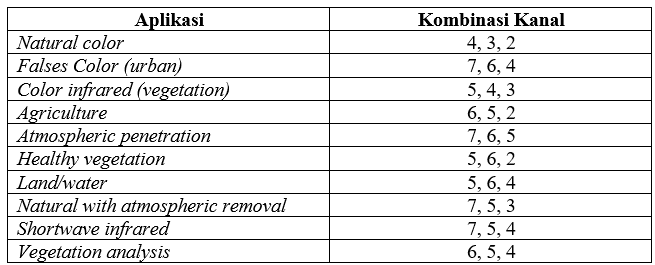.

Pada tahap ini melakukan kombinasi kanal pada **kanal 4, 5 dan 6** untuk menghasilkan tampilan citra landsat berupa analisis vegetasi pada analisis ini kami mengatur rasio pewarnaannya dengan nilai **min = 0.03 dan max = 0.97** bertujuan untuk menghasikan citra yang tidak terlalu gelap atau terang dimana rasio pewarnaan normal pada citranya yaitu **min = 0.2 dan max = 0.98**.
Untuk melakukan proses kombinasi kanal dapat menggunakan script berikut :

```
band_stacks = (6,5,4)
vmin, vmax = 0.03, 0.97
    
raw_rgb_img = xr.concat([raw_band[i] for i in band_stacks], dim="band")

fig, ax = plt.subplots(figsize=(7, 7))

raw_rgb_img.plot.imshow(ax=ax,
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
ax.set_title("Kombinasi Kanal - vegetation Analysis", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

```

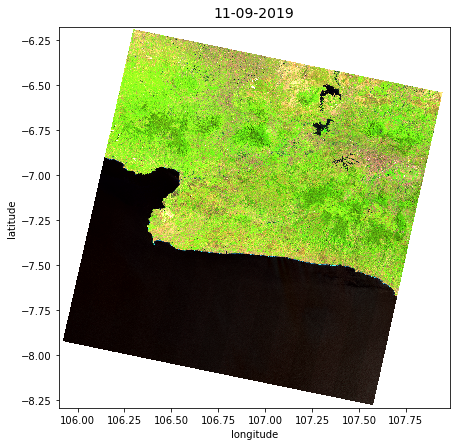

In [4]:
band_stacks = (6, 5, 4)
vmin, vmax = 0.03, 0.97 
year, month, date = landsat_dir[23:27], landsat_dir[27:29], landsat_dir[29:31]
time = f"{year}-{month}-{date}"
    
raw_rgb_img = xr.concat([raw_band[i] for i in band_stacks], dim="band")

fig, ax = plt.subplots(figsize=(7, 7))

raw_rgb_img.plot.imshow(ax=ax,
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
ax.set_title(f"{time[8:]}-{time[5:7]}-{time[:4]}", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

# Melakukan Kalibrasi Radiometrik

Koreksi Radiometrik (Radiometric Correction) dikelompokkan menjadi dua:
1. Kalibrasi Radiometrik
2. Koreksi Atmosferik.

Pada tahapan ini dilakukan proses kalibrasi radiometrik karena citra landsat yang digunakan yaitu citra landsat yang sudah dilakukan proses koreksi atmosperik oleh USGS. <br>

**`Kalibrasi Radiometrik`**  merupakan langkah pertama yang harus dilakukan saat kita mengolah data citra satelit. Tujuan utama dari Kalibrasi radiometrik ini adalah untuk mengubah data pada citra yang (pada umumnya) disimpan dalam bentuk Digital Number (DN) menjadi radiance dan/atau reflectance, bisa juga ke brightness temperature (untuk kanal Termal Infra Red). Terkait dengan Kalibrasi ini, ada istilah yang perlu diperhatikan, yakni Resolusi Radiometrik (radiometric resolution) yang menunjukkan `Berapa banyak bit yang digunakan dalam satu pixel`. Pada Citra Landsat 8 yang mengggunakan 16 bits, artinya digital number (DN) terletak dalam rentang 0 sampai 2 pangkat 16 (==65536). <br>
Ada dua cara yang umum digunakan (tergantung data yang tersedia):
1. Menggunakan Gain dan Offset
    
    Data yang diperlukan adalah radiance atau reflectance  multiple rescalling factor (GAIN) dan additive rescalling factor (OFFSET)

2. Menggunakan nilai radiance atau reflectance maksimum dan minimum.

Pada kali ini cara `kalibrasi` yang digunakan yaitu `menggunakan Gain dan offset untuk reflectance` . Dimana proses kalibrasi yang dilakukan Konversi Digital Number (DN) ke BoA (Bottom of Atmposhere) Reflectance; 
Konversi DN ke ToA Reflectance 
 Persamaan Konversi DN ke ToA Reflectance :

 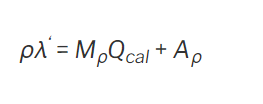

    Dimana : 
        * ρλ’ = BoA reflektansi
        * Mρ  = REFLECTANCE_MULT_BAND_x , di mana x adalah nomor Band (didapatkan dari metadata citra landsat) 
                  Note: Khusus L08 C2 L2 nilainya sama yaitu : 0.0000275
        * Qcal = Nilai digital number (DN)
        * Aρ = REFLECTANCE_ADD_BAND x , di mana x adalah nomor Band (didapatkan dari metadata citra landsat.) 
                  Note: Khusus L08 C2 L2 nilainya sama yaitu : -0.2

**Proses Kalibrasi Radiometrik dapat dilakukan dengan script sebagai berikut:**

``Proses Kalibrasi Radiometrik``

``````
calibrated_band = dict()

for i in raw_band.keys():
    if type(i) == int:
        if i < 10:
            calibrated_band[i] = (raw_band[i] * 0.0000275 + -0.2)
    else:
        calibrated_band[i] = raw_band[i]

calibrated_rgb_img = xr.concat([calibrated_band[i] for i in band_stacks], dim="band")

``````

`Membuat Figur`

> fig, axs = plt.subplots(1, 2, figsize=(15, 7))


``Menampilkan Hasil Sebelum dan Setelah Proses Kalibrasi Radiometrik``

``````

raw_rgb_img.plot.imshow(ax=axs[0],
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
axs[0].set_title("SEBELUM KALIBRASI RADIOMETRIK", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
axs[1].set_title("SESUDAH KALIBRASI RADIOMETRIK", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()

``````

In [5]:
calibrated_band = dict()

for i in raw_band.keys():
    if type(i) == int:
        if i < 10:
            calibrated_band[i] = (raw_band[i] * 0.0000275 + -0.2) 
    else:
        calibrated_band[i] = raw_band[i]

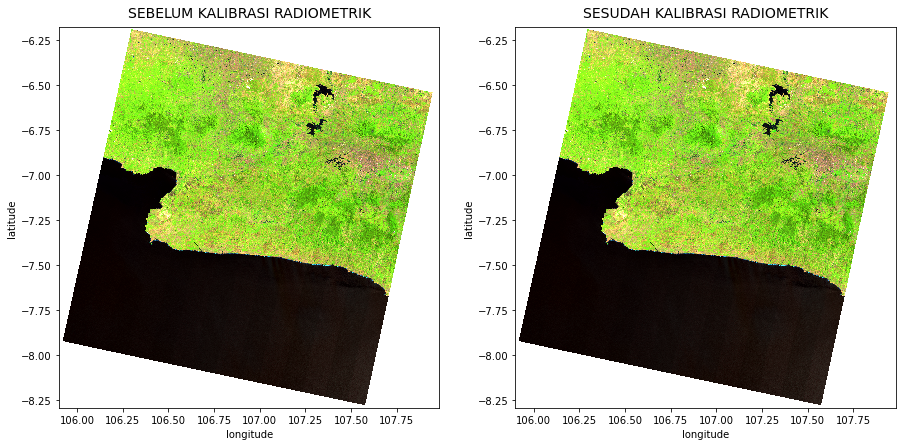

In [6]:
calibrated_rgb_img = xr.concat([calibrated_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

raw_rgb_img.plot.imshow(ax=axs[0],
                        vmin=raw_rgb_img.quantile(vmin),
                        vmax=raw_rgb_img.quantile(vmax))
axs[0].set_title("SEBELUM KALIBRASI RADIOMETRIK", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
axs[1].set_title("SESUDAH KALIBRASI RADIOMETRIK", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()

# Melakukan Overlay
Overlay merupakan kemampuan menempatkan suatu grafis peta diatas grafis peta lainnya. Overlay juga dapat didefinisikan sebagai penggabungan layer geografik yang berbeda untuk mendapatkan informasi baru (Darmawan & Suprayogi, 2017). Pada tahap ini dilakukan overlay pada citra hasil kombinasi kanal sebagai ilustrasi dengan data daerah penelitian berupa peta administrasi Kota Bogor. Proses Overlay dapat dilakukan dengan script berikut ini :

`Membaca Peta Adminitrasi Kota Bogor`

> shape = gpd.read_file("Kota Bogor/kecamatan.shp").to_crs(coor_ref)

`Membuat Figure`

> fig, axs = plt.subplots(1, 3, figsize=(21, 7), gridspec_kw={'width_ratios': [1.2, 1.2, 1.2]})

`Menampilkan Peta Adminitrasi Kota Bogor`

`````
shape.plot(ax = axs[0])
axs[0].set_title("Peta Adminitrasi Kota Bogor", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")
`````

`Menampilkan Kombinasi Kanal-Vegetation Analysis`

`````
calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
axs[1].set_title("Kombinasi Kanal - Vegetation Analysis", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

`````

`Proses Overlay dan Menampilkan Hasil Overlay`

`````
calibrated_rgb_img.plot.imshow(ax=axs[2],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
shape.plot(ax=axs[2])
axs[2].set_title("Hasil Overlay", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

`````


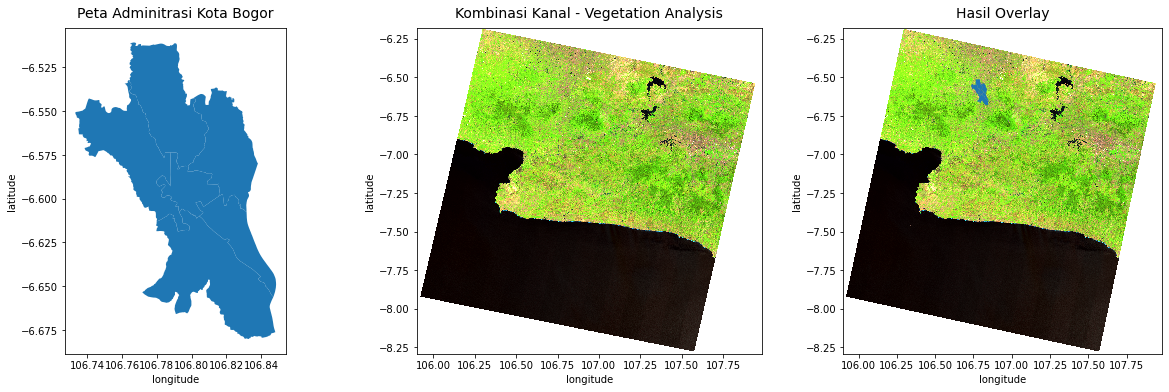

In [7]:
shape = gpd.read_file("Kota Bogor/kecamatan.shp").to_crs(coor_ref)

fig, axs = plt.subplots(1, 3, figsize=(21, 6), gridspec_kw={'width_ratios': [1.2, 1.2, 1.2]})

shape.plot(ax = axs[0])
axs[0].set_title("Peta Adminitrasi Kota Bogor", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[1],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
axs[1].set_title("Kombinasi Kanal - Vegetation Analysis", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

calibrated_rgb_img.plot.imshow(ax=axs[2],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
shape.plot(ax=axs[2])
axs[2].set_title("Hasil Overlay", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

# Melakukan Pemotongan Citra

Data spasial yang digunakan untuk penelitian ini adalah citra Landsat 8 Collection 2 Level 2 Path 122 Row 65 yang diperoleh dari United States Geological Survey (USGS: https://earthexplorer.usgs.gov/). Citra satelit yang diperoleh mencakup wilayah yang sangat luas, sedangkan citra yang dibutuhkan pada penelitian ini hanya wilayah Kota Bogor. Citra perlu dilakukan proses overlay dengan peta administrasi Kota Bogor untuk mengetahui batas dan letak wilayah Kota Bogor pada citra tersebut. Setelah dilakukan proses overlay, citra dipotong berdasarkan batas wilayah Kota Bogor untuk memperoleh citra yang sesuai dengan wilayah penelitian. <br>
Untuk melakukan pemotongan citra dapat dilakukan menggunakan script berikut :

`Proses Pemotongan Citra`
```````
clipped_band = dict()

for i in calibrated_band.keys():
    clipped_band[i] = calibrated_band[i].rio.clip(shape.geometry.apply(mapping), shape.crs)

clipped_rgb_img = xr.concat([clipped_band[i] for i in band_stacks], dim="band")

```````

`Membuat Figur`

> fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2.1, 1.1]})


`Menampilkan Citra Sebelum dilakukan Pemotongan Citra`

``````
calibrated_rgb_img.plot.imshow(ax=axs[0],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
shape.plot(ax=axs[0])
axs[0].set_title("Sebelum Pemotongan Citra", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

``````

`Menampilkan Hasil Pemotongan Citra`

``````

clipped_rgb_img.plot.imshow(ax=axs[1],
                            vmin=clipped_rgb_img.quantile(vmin),
                            vmax=clipped_rgb_img.quantile(vmax))
axs[1].set_title("Hasil Pemotongan Citra", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()
``````

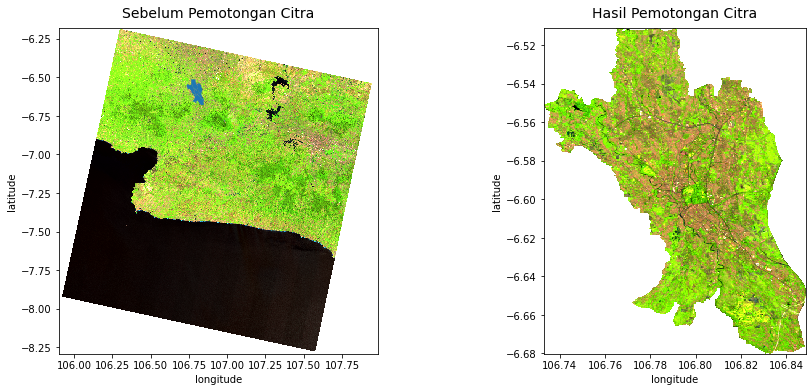

In [8]:
clipped_band = dict()

for i in calibrated_band.keys():
    clipped_band[i] = calibrated_band[i].rio.clip(shape.geometry.apply(mapping), shape.crs)

clipped_rgb_img = xr.concat([clipped_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2.1, 1.1]})

calibrated_rgb_img.plot.imshow(ax=axs[0],
                               vmin=calibrated_rgb_img.quantile(vmin),
                               vmax=calibrated_rgb_img.quantile(vmax))
shape.plot(ax=axs[0])
axs[0].set_title("Sebelum Pemotongan Citra", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

clipped_rgb_img.plot.imshow(ax=axs[1],
                            vmin=clipped_rgb_img.quantile(vmin),
                            vmax=clipped_rgb_img.quantile(vmax))
axs[1].set_title("Hasil Pemotongan Citra", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()

# Penghapusan Awan dan Bayangan Awan

Proses menghapus awan dan bayangan awan dilakukan menggunakan band quality assessment (BQA). BQA adalah suatu kanal yang dibuat oleh Landsat yang berguna untuk mendeteksi anomali pada data seperti salju, awan dan bayangannya (Sinabutar et al. 2020).
Namun Karena wilayah Kota Bogor memiliki 2 musim yaitu musim kemarau dan musim hujan maka hanya dilakukan proses penghapusan awan dan bayangannya saja. <br>
Klasifikasi awan, bayangannya, dan area bersih pada BQA dasarnya menggunakan daftar piksel interpetasi yang telah dikonversi ke bentuk biner yang sudah tersedia di web USGS .

Tabel Daftar Pixel Interpetasi Biner BQA
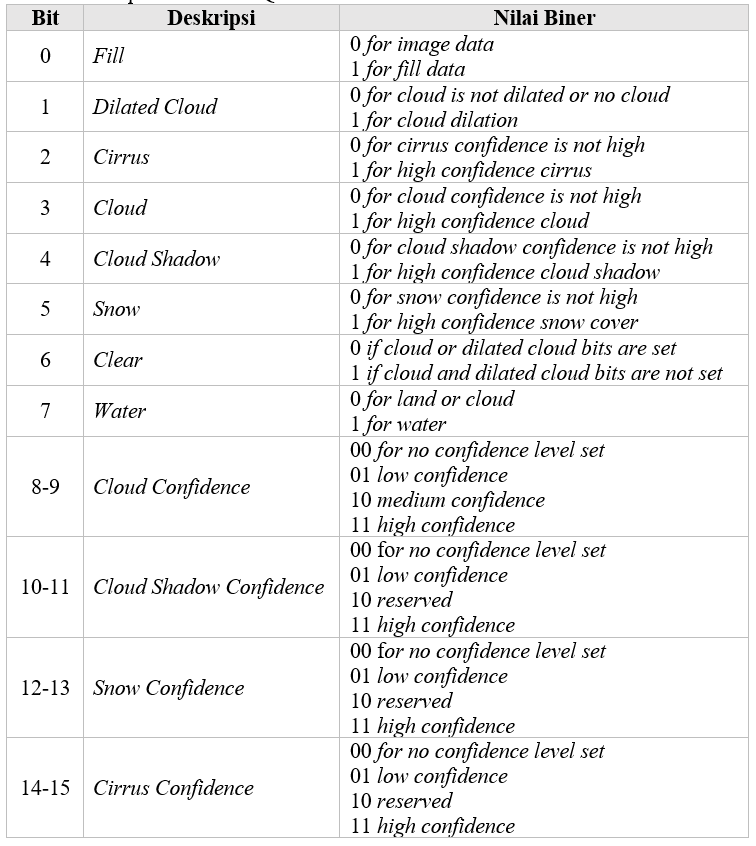

Tahap penghapusan awan dapat menggunakan script sebagai berikut :

`Konvert dataFrame QA_Pixel ke bentuk List`

> qa_pixel = clipped_band["QA_PIXEL"].values.tolist()

`Membuat Variabel dengan tipe data List`

> removed_pixel = list()

`Proses Penghapusan Awan dan Bayangannya`

```````
for i in qa_pixel:
    for j in i:
        if j != -9999:
            bin_pixel = np.binary_repr(int(j))
            if bin_pixel[-4] == "1" or bin_pixel[-5] == "1" or bin_pixel[-10] == "1":
                dec_pixel = int(bin_pixel, 2)
                if dec_pixel not in removed_pixel:
                    removed_pixel.append(dec_pixel)
```````

`Membuat variabel yang menampung data yang sudah dilakukan penghapusan awan dan bayangannya`

```````
cleared_band = dict()

for i in [*clipped_band.keys()][:-1]:
    cleared_band[i] = clipped_band[i].where(~clipped_band["QA_PIXEL"].isin(removed_pixel))
    
cleared_rgb_img = xr.concat([cleared_band[i] for i in band_stacks], dim="band")
```````

`Menampilkan citra sebelum dan sesudah penghapusan awan dan bayangannya`
```````
fig, axs = plt.subplots(1, 2, figsize=(11, 7))

clipped_rgb_img.plot.imshow(ax=axs[0],
                            vmin=clipped_rgb_img.quantile(vmin),
                            vmax=clipped_rgb_img.quantile(vmax))
axs[0].set_title("SEBELUM PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

cleared_rgb_img.plot.imshow(ax=axs[1], 
                            vmin=cleared_rgb_img.quantile(vmin),
                            vmax=cleared_rgb_img.quantile(vmax))
axs[1].set_title("SESUDAH PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()
````````

`Menghitung Luas Area Adminitrasi Kota Bogor`
`````
area = clipped_band[[*cleared_band.keys()][0]].count().values
area_km = area * 900 / 1000000
`````
`Menghitung Luas Area Kota Bogor Tanpa awan`
``````
cleared_area = cleared_band[[*cleared_band.keys()][0]].count().values
cleared_area_km = cleared_area * 900 / 1000000
cleared_area_pc = round(cleared_area_km / area_km * 100, 2)
```````
`Menampilkan luas Area Peta Adminitrasi Kota Bogor dan Luas Area Kota Bogor Tanpa Awan`
`````
print(f"luas kota bogor: {area_km} km\N{SUPERSCRIPT TWO}")
print(f"luas kota bogor tanpa awan: {cleared_area_km} km\N{SUPERSCRIPT TWO} atau {cleared_area_pc}%")
```````

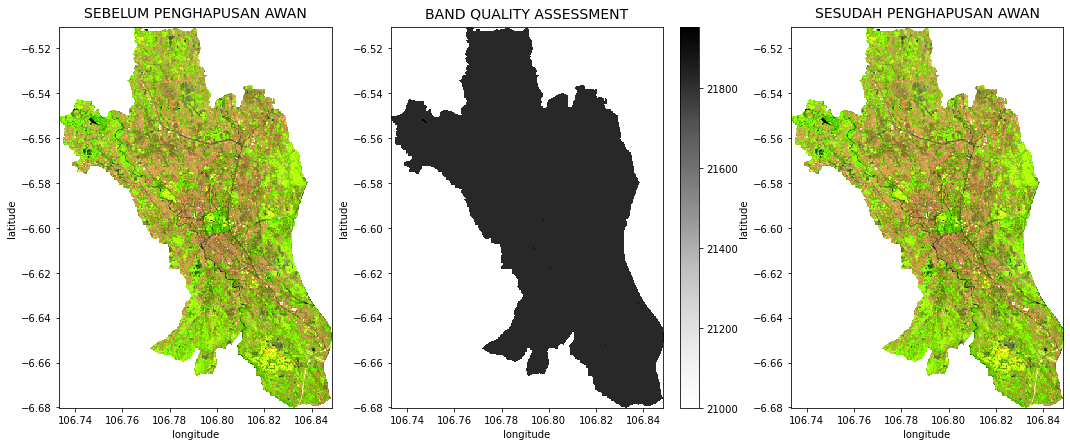

In [9]:
qa_pixel = clipped_band["QA_PIXEL"].where(~clipped_band["QA_PIXEL"].isin(-9999))
qa_pixel_arr = qa_pixel.values.tolist()
removed_pixel = list()

for i in qa_pixel_arr:
    for j in i:
        if ~np.isnan(j):
            bin_pixel = np.binary_repr(int(j))
            if bin_pixel[-4] == "1" or bin_pixel[-5] == "1" or bin_pixel[-10] == "1":
                dec_pixel = int(bin_pixel, 2)
                if dec_pixel not in removed_pixel:
                    removed_pixel.append(dec_pixel)

cleared_band = dict()

for i in [*clipped_band.keys()][:-1]:
    cleared_band[i] = clipped_band[i].where(~clipped_band["QA_PIXEL"].isin(removed_pixel))
    
cleared_rgb_img = xr.concat([cleared_band[i] for i in band_stacks], dim="band")

fig, axs = plt.subplots(1, 3, figsize=(18, 7),  gridspec_kw={'width_ratios': [1, 1.25, 1]})

clipped_rgb_img.plot.imshow(ax=axs[0],
                            vmin=clipped_rgb_img.quantile(vmin),
                            vmax=clipped_rgb_img.quantile(vmax))
axs[0].set_title("SEBELUM PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

qa_pixel.plot.imshow(ax=axs[1], cmap="Greys", vmin=21000, vmax=qa_pixel.max())
axs[1].set_title("BAND QUALITY ASSESSMENT", fontsize=14, pad=10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

cleared_rgb_img.plot.imshow(ax=axs[2], 
                            vmin=cleared_rgb_img.quantile(vmin),
                            vmax=cleared_rgb_img.quantile(vmax))
axs[2].set_title("SESUDAH PENGHAPUSAN AWAN", fontsize=14, pad=10)
axs[2].set_xlabel("longitude")
axs[2].set_ylabel("latitude")

plt.show()

In [10]:
area = clipped_band[[*cleared_band.keys()][0]].count().values
area_km = area * 900 / 1000000
cleared_area = cleared_band[[*cleared_band.keys()][0]].count().values
cleared_area_km = cleared_area * 900 / 1000000
cleared_area_pc = round(cleared_area_km / area_km * 100, 2)
print(f"luas kota bogor: {area_km} km\N{SUPERSCRIPT TWO}")
print(f"luas kota bogor tanpa awan: {cleared_area_km} km\N{SUPERSCRIPT TWO} atau {cleared_area_pc}%")

luas kota bogor: 116.8146 km²
luas kota bogor tanpa awan: 116.8146 km² atau 100.0%


# Menampilkan Citra Hasil Pra Pengolahan

Tahap menampilkan citra hasil pra pengolahan dapat menggunakan script berikut :
``````
fig, axs=plt.subplots(1, 3, figsize=(15, 6))

i = 0
for j in range(3):
    cleared_band[[*cleared_band.keys()][i]].plot.imshow(ax=axs[j], cmap="OrRd")
    axs[j].set_title(f"Band {[*cleared_band.keys()][i]}")
    axs[j].set_xlabel("longitude")
    axs[j].set_ylabel("latitude")
    i += 1
        
plt.show()
``````

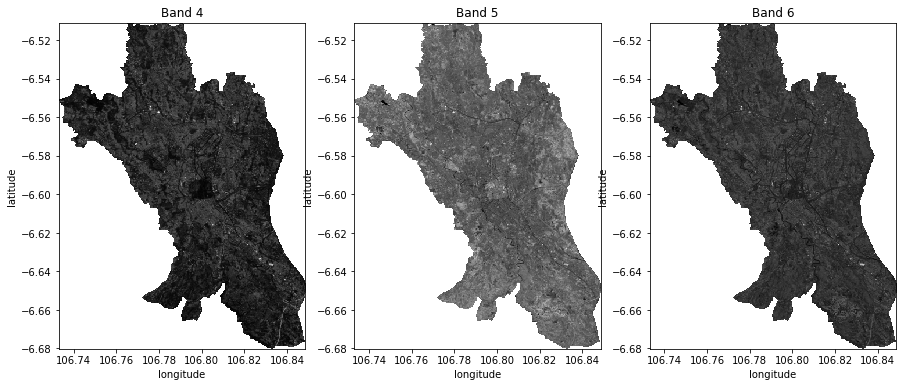

In [11]:
fig, axs=plt.subplots(1, 3, figsize=(15, 6))

i = 0
for j in range(3):
    cleared_band[[*cleared_band.keys()][i]].plot.imshow(ax=axs[j], cmap="Greys_r", add_colorbar = False)
    axs[j].set_title(f"Band {[*cleared_band.keys()][i]}")
    axs[j].set_xlabel("longitude")
    axs[j].set_ylabel("latitude")
    i += 1
        
plt.show()

# Menyimpan Citra Hasil Pra Pengolahan

In [12]:
year, month, date = landsat_dir[23:27], landsat_dir[27:29], landsat_dir[29:31]
time = f"{year}-{month}-{date}"

if not os.path.exists(f"output/preprocessed/{time}"):
    os.makedirs(f"output/preprocessed/{time}")

for i in cleared_band.keys():
    cleared_band[i].rio.to_raster(f"output/preprocessed/{time}/B{i}.TIF")

# Membuat data citra (awan) dalam csv

In [13]:
import csv
df = pd.read_csv("dataset/NDVI.csv")
date = df.loc[df["date"] == time, "date"]
if len(date) == 0:
    with open("dataset/NDVI.csv", newline ="", mode="a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([time, cleared_area_km, cleared_area_pc])
    print("Data berhasil ditambahkan")
    csv_file.close()
elif date.values == time:
    print("Data sudah ada")
else:
    print("Tidak ada proses yang dilakukan")

Data sudah ada


In [14]:
df = pd.read_csv("dataset/NDVI.csv")
df = df.loc[df["clear_area_pc"] == 100]
df

,date,clear_area_km,clear_area_pc
15,2015-08-31,116.8137,100.0
34,2016-06-30,116.8209,100.0
58,2017-07-19,116.8137,100.0
84,2018-09-24,116.8182,100.0
102,2019-07-25,116.8209,100.0
105,2019-09-11,116.8146,100.0
118,2020-05-24,116.8218,100.0
